In [1]:
import numpy as np
import pandas as pd
from scipy.signal import fftconvolve, gaussian
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

from lab3.experiment.base import ImagingExperiment, fetch_trials
from lab3.misc.progressbar import ProgressBar

sns.set(style='ticks')

# Some quick-and-dirty analysis

We can access the behavior data via the experiment object's `format_behavior_data` method, which will by default synchronize the behavior samples with the imaging data. Then using the spikes we just extracted, we can make some plots of the spatial activity of each neuron. I've written a short convenience function to do this for now, but we'll build more permanent tools into the lab3 repo soon. 

In [47]:
# Here I've written a couple of functions that we'll use later 

def get_ctx_place_maps(expt, n_position_bins=100, sigma=3,
                       velocity_threshold=5):
    """This function takes an experiment object and returns an array of 
    placemaps for each cell, along with the context ID of every trial.
    
    Parameters
    ----------
    expt : lab3.experiment.baseImagingExperiment
    n_position_bins : int, optional
        Number of discrete position bins, default 100
    sigma : int, optional
        Standard deviation of gaussian smoothing kernel, default 3 (bins)
    velocity_threshold : float, optional
        Minimum speed of the animal to retain data, default 5 cm/sec
    
    Returns
    -------
    place_maps : array (n_rois, n_laps, n_position_bins)
        Array of smoothed spatial rasters 
    ctx_id : array (n_laps)
        Context ID of each lap"""
    
    # get behavior data synchronized to the imaging data
    beh_data = expt.format_behavior_data()
    laps = beh_data['lap_bin']
    velocity = beh_data['velocity']

    # figure out what samples are during ITIs, and also the ctx ID of each lap
    try:
        ctx_id = beh_data['ctx_1'].astype('int') \
                 - beh_data['ctx_2'].astype('int')
    except KeyError:
        ctx_id = beh_data['ctx_1'].astype('int') \
                 - beh_data['ctx_3'].astype('int')
    iti = ctx_id == 0
    
    # extend ITI by one frame to correct an error in behavior data formatting
    iti[np.where(np.diff(iti.astype('int'))==-1)[0] + 1] = True
    
    # make list of context IDs for each trial
    ctx_id = np.asarray(['A' if ctx_id[laps==lap].mean() > 0 else 'B' 
                         for lap in np.unique(laps)])

    # discretize position into n_position_bins bins
    pos = (beh_data['treadmillPosition'] * n_position_bins).astype('int')

    # binarize spikes
    spikes = expt.signals(label='suite2p', signal_type='spikes').gt(0)
    
    # iterate over laps to create spatial tuning array
    print(f'Calculation spatial rasters for {expt}')
    place_maps = np.zeros((len(np.unique(laps)) - 1, spikes.shape[0], 
                           n_position_bins))
    p = ProgressBar(len(np.unique(laps)) - 1)
    for lap in range(len(np.unique(laps)) - 1):
        
        # only count spikes on the current lap while the animal is 
        # running > velocity_threshold cm/sec, and not during ITI periods 
        valid_samples = (laps==lap) & ~iti & (velocity > velocity_threshold)

        # calculate spike rate at each position
        place_maps[lap, :] = np.stack(
            [np.mean(spikes.iloc[:, (valid_samples) & (pos==p)], axis=1) 
             for p in range(100)]).T
        
        p.update(lap)
    p.end()

    # replace nans with zeros and smooth with a gaussian
    place_maps = np.nan_to_num(np.swapaxes(place_maps, 0, 1))
    k = gaussian(18, 3)
    k /= k.sum()
    place_maps = np.apply_along_axis(fftconvolve, -1, place_maps, k, mode='same') 
    
    return place_maps, ctx_id


def plot_spatial_rasters(rasters, bar=30, plot_name='test'):
    """Creates a pdf of spatial raster plots
    
    Parameters 
    ----------
    rasters : array (n_rois, n_laps, n_position_bins)
    bar : int
        Draw a horizontal bar across the plot at this lap
    """
    
    with PdfPages(f'{plot_name}.pdf') as pdf:
        
        p = ProgressBar(len(rasters))
        for counter in range(0, len(rasters), 18):

            print(counter, end=' ')

            plt.figure(figsize=(13, 22))
            for i in range(18):

                if counter + i >= len(rasters):
                    continue

                ax = plt.subplot(6, 3, 1 + i)
                sns.heatmap(rasters[counter + i] / np.max(rasters[counter + i]), 
                            vmin=0, vmax=1, rasterized=True, cmap='magma')
                plt.yticks([15, 40], ['$A$', '$B$'])
                plt.ylim([50, 0])
                plt.axhline(bar, color='white')
                plt.xticks([0, 50, 100], [0, 1.5, 3], 
                           rotation=False)
                plt.ylabel('Trials')
                plt.xlabel('Position (m)')

                sns.despine(ax=ax)
                
                p.update(counter)

            plt.tight_layout()

            pdf.savefig()
            plt.close()
        
        p.end()

## Actual analysis starts here 
As before, we need to instantiate experiment objects for each dataset that we want to include. Here I've loaded up a WT mouse from my data to serve as the control.

In [3]:
df_ids = fetch_trials(project_name='steph', mouse_name='sah004')

# make a list of ImagingExperiment objects, keep track of genotypes
expt_list = []
for trial_id in df_ids:
    expt = ImagingExperiment(trial_id)
    expt.genotype = 'df16'
    expt_list.append(expt)
    
# load wt mouse
expt = ImagingExperiment(21971)
expt.genotype = 'wt'
expt_list.append(expt)

In [16]:
# calculate place maps for each experiment
results = []
for expt in expt_list:
    
    rasters, _ = get_ctx_place_maps(expt)
    ctx_a_sort = np.argmaxnp
    
    results.append({'genotype': expt.genotype,
                    'expt': expt.trial_id,
                    
                    # For the df mice, the sessions have 30 trials of A followed by
                    # B trials, so we'll take the first 50 trials that they both share in common.
                    # For the wt mouse, the session began with 35 trials of A, so we'll start at
                    # trial 5 so that everything lines up                 
                    'rasters': rasters[:, 0:50] if expt.genotype == 'df16' \
                               else rasters[:, 5:55]})
    
results = pd.DataFrame(results)

Calculation spatial rasters for <ImagingExperiment: trial_id=22040 mouse_id=880 experimentType=contextAlternationAB_abbreviated>
	[====================] 100%
Calculation spatial rasters for <ImagingExperiment: trial_id=22039 mouse_id=880 experimentType=contextAlternationAB_abbreviated>
	[====================] 100%
Calculation spatial rasters for <ImagingExperiment: trial_id=21971 mouse_id=871 experimentType=contextAlternationAB>
	[====================] 100%


In [ ]:
for _, row in results.iterrows():
    
    plot_spatial_rasters(row['rasters'], plot_name=f"{row['genotype']}_{row['expt']}")

	[====================] 100%
	[====================] 100%
	[=================== ] 97%

In [75]:
from scipy.stats import zscore

burst_df = []
for _, row in results.iterrows():
    
    z_laprate = zscore(row['rasters'].mean(axis=-1), axis=1)
    
    for cell_idx, laprate in enumerate(z_laprate):
        for lap_idx, rate in enumerate(laprate):
            
            burst_df.append({'expt': row['expt'],
                             'genotype': row['genotype'],
                             'cell_idx': cell_idx,
                             'lap_idx': lap_idx,
                             'rate': rate})

In [76]:
burst_df = pd.DataFrame(burst_df)

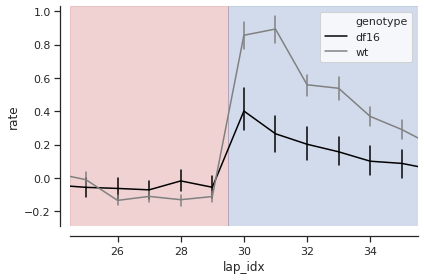

In [93]:
with PdfPages('ctx_switch_population_rate.pdf') as pdf:
    plt.figure()
    sns.lineplot(x='lap_idx', y='rate', data=burst_df, hue='genotype', 
                 ci=99, err_style='bars', palette=['black', 'grey'])
    plt.xlim([24.5, 35.5])
    plt.axvspan(24.5, 29.5, color='r', alpha=0.25)
    plt.axvspan(29.5, 35.5, color='b', alpha=0.25)
    
    sns.despine(offset=10)
    plt.tight_layout()
    
    pdf.savefig()

In [107]:
# some quick stats 
from scipy.stats import ttest_ind

for lap in range(25, 36):
    
    p_val = ttest_ind(burst_df[(burst_df.lap_idx==lap) & (burst_df.genotype=='df16')].rate,
                      burst_df[(burst_df.lap_idx==lap) & (burst_df.genotype=='wt')].rate,
                      equal_var=False, nan_policy='omit')[1]
    
    print(f'Lap {lap} - p = {p_val}, bonferroni p = {p_val * 11}')

Lap 25 - p = 0.10252888044744704, bonferroni p = 1.1278176849219175
Lap 26 - p = 0.008374540298500415, bonferroni p = 0.09211994328350456
Lap 27 - p = 0.12128861350442183, bonferroni p = 1.3341747485486402
Lap 28 - p = 5.3954335479529877e-05, bonferroni p = 0.0005934976902748286
Lap 29 - p = 0.04729958726522045, bonferroni p = 0.5202954599174249
Lap 30 - p = 2.5826484600064387e-16, bonferroni p = 2.8409133060070828e-15
Lap 31 - p = 1.5730457770335076e-31, bonferroni p = 1.730350354736858e-30
Lap 32 - p = 1.1935848855641462e-13, bonferroni p = 1.3129433741205608e-12
Lap 33 - p = 1.4156064798475758e-17, bonferroni p = 1.5571671278323333e-16
Lap 34 - p = 9.94903889546616e-11, bonferroni p = 1.0943942785012776e-09
Lap 35 - p = 4.0856170405783063e-07, bonferroni p = 4.494178744636137e-06


### Next...
Here's a sloppy plot of the population rasters around the time of the context switch...

In [204]:
spikes = expt_list[0].signals(label='suite2p', signal_type='spikes')
beh_data = expt_list[0].format_behavior_data()

pos = beh_data['treadmillPosition']
iti = ~(beh_data['ctx_1'] + beh_data['ctx_2'])
iti[np.where(np.diff(iti.astype('int'))==-1)[0] + 1] = True
is_running = expt_list[0].velocity() > 5

In [205]:
# only plot time bins that are not during ITIs, and while the animal is running > 5cm/s
# we'll only plot from time bins 8515 to 10500, which cover the 3 laps before and after the context switch
time_idx = np.arange(len(iti))
time_idx = time_idx[~iti & is_running]
time_idx = time_idx[(time_idx>=8515)&(time_idx<10500)]

# figure out the sort order for cells in ctx A vs ctx B
sort_idx_A = np.argsort(np.argmax(results.iloc[0].rasters[:, 0:30].mean(axis=1).squeeze(), axis=1))
sort_idx_B = np.argsort(np.argmax(results.iloc[0].rasters[:, 30:].mean(axis=1).squeeze(), axis=1))

# get spike times (x) and cell number (y) for scatter plots, for both A and B sorts 
yA, xA = np.where(spikes.iloc[sort_idx_A, time_idx].values)
yB, xB = np.where(spikes.iloc[sort_idx_B, time_idx].values)

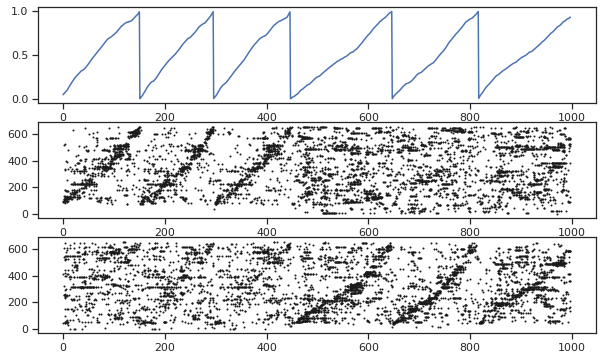

In [214]:
with PdfPages('population_scatter_plot.pdf') as pdf:
    
    plt.figure(figsize=(10, 6))
    plt.subplot(3, 1, 1)
    plt.plot(pos[time_idx])

    plt.subplot(3, 1, 2)
    plt.scatter(xA, yA, color='k', s=1)

    plt.subplot(3, 1, 3)
    plt.scatter(xB, yB, color='k', s=1)
    
    pdf.savefig()

In [630]:
# time shift analysis...
rasters = results.iloc[2].rasters[:, 30:, 0:50]

In [660]:
from scipy.stats import pearsonr

def time_shift_correlations(rasters):
    
    template_tuning = rasters[:, 10:, :].mean(axis=1).flatten()

    corr_curve = []
    for lap in range(0, 5):
        corr_curve.append([pearsonr(np.roll(rasters[:, lap, :].squeeze(), axis=1, shift=delta)[:, :].flatten(),
                           template_tuning)[0] for delta in np.arange(-20, 21)][::-1])
        
    corr_curve = np.stack(corr_curve)
    corr_curve -= np.min(corr_curve, axis=1).reshape(-1, 1)
    corr_curve /= np.max(corr_curve, axis=1).reshape(-1, 1)
    
    return corr_curve

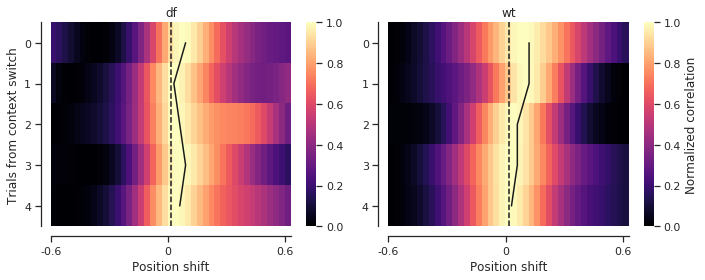

In [676]:
with PdfPages('time_shift_plot.pdf') as pdf:
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    corr_mat = time_shift_correlations(results.iloc[0].rasters[:, 30:, 0:50])

    sns.heatmap(corr_mat, cmap='magma')
    plt.plot(np.argmax(corr_mat, axis=1) + 1, np.linspace(0.5, 4.5, 5), color='k')
    plt.axvline(20.5, color='k', linestyle='--')
    plt.ylim([5, 0])
    plt.title('df')
    plt.xticks([0, 20, 40], [-0.6, 0, 0.6])
    plt.xlabel('Position shift')
    plt.ylabel('Trials from context switch')


    plt.subplot(1, 2, 2)
    corr_mat = time_shift_correlations(results.iloc[2].rasters[:, 30:, 0:50])

    sns.heatmap(corr_mat, cmap='magma', cbar_kws={'label': 'Normalized correlation'})
    plt.plot(np.argmax(corr_mat, axis=1) + 1, np.linspace(0.5, 4.5, 5), color='k')
    plt.axvline(20.5, color='k', linestyle='--')
    plt.ylim([5, 0])
    plt.title('wt')
    plt.xticks([0, 20, 40], [-0.6, 0, 0.6])
    plt.xlabel('Position shift')

    sns.despine(offset=10)
    plt.tight_layout()
    
    pdf.savefig()

0.6